In [1]:
import os

os.chdir(r'C:\Users\carlo\GitHub\ProjectBuffalo')

import buffalo.ingestion as ingestion
import buffalo.predictor as predictor
import torch
import pickle

In [2]:
ingestor = ingestion.DataIngestion(ingestion.enum.API.ADVANTAGE)

In [3]:
ingestor.load_data(r'cached_data/ingestion.sqlite')

In [4]:
target_symbol = 'AAPL'

In [5]:
ingestor.data['ADJUSTED_DAILY_STOCK'].symbol.unique()

array(['AAPL', 'MSFT', 'IBM', 'META', 'JNJ', 'PFE', 'UNH', 'MARK', 'XLV',
       'JPM', 'BAC', 'GS', 'MS', 'XLF', 'PG', 'KO', 'PEP', 'NKE', 'XLP',
       'GE', 'HON', 'UTX', 'MMM', 'XLI'], dtype=object)

In [6]:
target_stock = ingestor.data['ADJUSTED_DAILY_STOCK'].query('symbol == @target_symbol')[['open', 'high', 'low', 'adjusted_close', 'volume']]

In [7]:
other_stocks = ingestor.data['ADJUSTED_DAILY_STOCK'].query('symbol != @target_symbol')

In [8]:
for symbol in ['AAPL', 'IBM', 'JNJ', 'PFE', 'UNH', 'XLV', 'JPM', 'BAC', 'GS', 'XLF', 'PG', 'KO', 'PEP', 'NKE', 'XLP', 'GE', 'HON', 'MMM', 'XLI']:
    temp = other_stocks[other_stocks['symbol'] == symbol][['open', 'high', 'low', 'adjusted_close', 'volume']].rename(columns={'adjusted_close': 'close'})
    temp.columns = symbol + '_' + temp.columns
    target_stock = predictor.util.align_dataframe_by_time(target_stock, temp)

In [9]:
target_income_statement = ingestor.data['COMPANY_INCOME_STATEMENT'].query('symbol == @target_symbol & freq == "quarterly"').drop(columns=['reported_currency', 'symbol', 'freq', 'function']).dropna(axis=1, how='all')
target_balance_sheet = ingestor.data['COMPANY_BALANCE_SHEET'].query('symbol == @target_symbol & freq == "quarterly"').drop(columns=['reported_currency', 'symbol', 'freq', 'function']).dropna(axis=1, how='all')
target_cash_flow = ingestor.data['COMPANY_CASH_FLOW'].query('symbol == @target_symbol & freq == "quarterly"').drop(columns=['reported_currency', 'symbol', 'freq', 'function', 'net_income']).dropna(axis=1, how='all')
fed_funds_rate = ingestor.data['FEDERAL_FUNDS_RATE'][['value']].rename(columns={'value': 'effective_federal_funds_rate'}).dropna(axis=1, how='all')
payroll = ingestor.data['NONFARM_PAYROLL'][['value']].rename(columns={'value': 'total_nonfarm_payroll'}).dropna(axis=1, how='all')
cpi = ingestor.data['CPI'][['value']].rename(columns={'value': 'consumer_price_index'}).dropna(axis=1, how='all')
unemployment = ingestor.data['UNEMPLOYMENT'][['value']].rename(columns={'value': 'unemployment_rate'}).dropna(axis=1, how='all')
real_gdp = ingestor.data['REAL_GDP'][['value']].rename(columns={'value': 'real_gross_domestic_product'}).dropna(axis=1, how='all')
real_gdp_per_capita = ingestor.data['REAL_GDP_PER_CAPITA'][['value']].rename(columns={'value': 'real_gross_domestic_product_per_capita'})
treasury_yield = ingestor.data['TREASURY_YIELD'][['value', 'maturity']].pivot(columns=['maturity'], values=['value']).dropna(axis=1, how='all')
treasury_yield.columns = 'treasury_yield_' + treasury_yield.columns.droplevel(level=0)

In [23]:
sma = ingestor.data['SMA'].query('symbol == @target_symbol & interval == "daily"')
roc = ingestor.data['ROC'].query('symbol == @target_symbol & interval == "daily"')
ht_sine = ingestor.data['HT_SINE'].query('symbol == @target_symbol & interval == "daily"')
mom = ingestor.data['MOM'].query('symbol == @target_symbol & interval == "daily"')
sma = sma.pivot(columns=['time_period', 'series_type'], values=['sma']).dropna(axis=1, how='all')
sma.columns = sma.columns.map(lambda x: '-'.join([str(t) for t in x]))
target_stock = predictor.util.align_dataframe_by_time(target_stock, sma)
roc = roc.pivot(columns=['time_period', 'series_type'], values=['roc']).dropna(axis=1, how='all')
roc.columns = roc.columns.map(lambda x: '-'.join([str(t) for t in x]))
target_stock = predictor.util.align_dataframe_by_time(target_stock, roc)
ht_sine = ht_sine.pivot(columns=['time_period', 'series_type'], values=['lead_sine', 'sine']).dropna(axis=1, how='all')
ht_sine.columns = ht_sine.columns.map(lambda x: '-'.join([str(t) for t in x]))
target_stock = predictor.util.align_dataframe_by_time(target_stock, ht_sine)
mom = mom.pivot(columns=['time_period', 'series_type'], values=['mom']).dropna(axis=1, how='all')
mom.columns = mom.columns.map(lambda x: '-'.join([str(t) for t in x]))
target_stock = predictor.util.align_dataframe_by_time(target_stock, mom)

In [24]:
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, fed_funds_rate)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, payroll)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, cpi)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, unemployment)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, real_gdp)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, real_gdp_per_capita)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, treasury_yield)
print(target_stock.shape)
#target_stock = predictor.util.align_dataframe_by_time(target_stock, target_income_statement)
#print(target_stock.shape)
#target_stock = predictor.util.align_dataframe_by_time(target_stock, target_balance_sheet)
#print(target_stock.shape)
#target_stock = predictor.util.align_dataframe_by_time(target_stock, target_cash_flow)
#print(target_stock.shape)

(5692, 184)
(5691, 185)
(5671, 186)
(5671, 187)
(5671, 188)
(5286, 189)


c:\Users\carlo\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 83, using nperseg = 83
  warnings.warn('nperseg = {0:d} is greater than input length '


(5286, 190)
(5246, 195)


In [14]:
pickle.dump(target_stock, open(r'cached_data/target_stock.pickle', 'wb'))

In [15]:
target_stock = pickle.load(open('cached_data/target_stock.pickle', 'rb'))

In [16]:
time_series_data = predictor.util.TimeSeriesData(endog=target_stock[['adjusted_close']], exog=target_stock.drop(columns=['adjusted_close']), seq_len=180, name='DAILY_ADJUSTED_CLOSE_APPL')

In [17]:
import buffalo.predictor.models as modeling

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 642.5291830765514. Test loss: 37470.65002441406.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 1, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


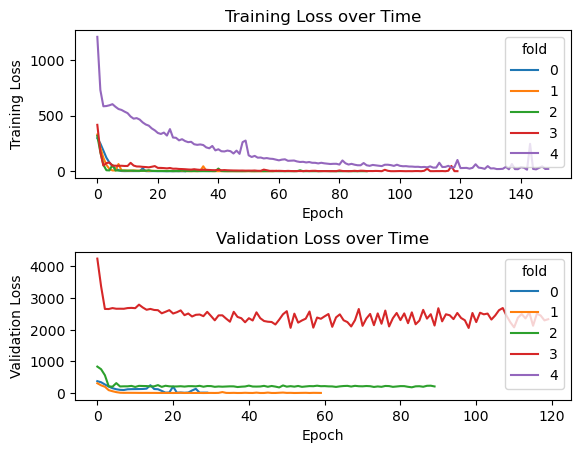

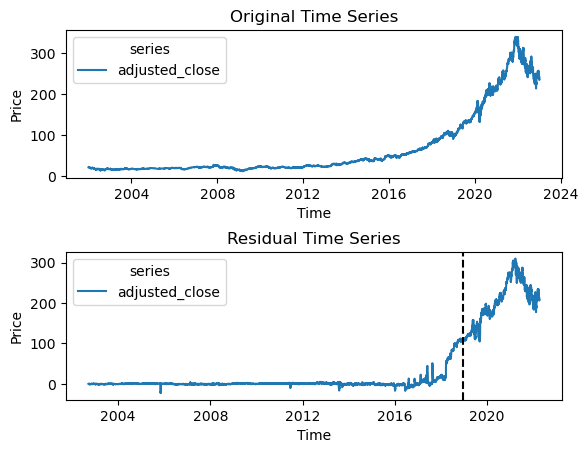

In [18]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=False, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 547.1858508563959. Test loss: 35742.98912811279.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 2, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


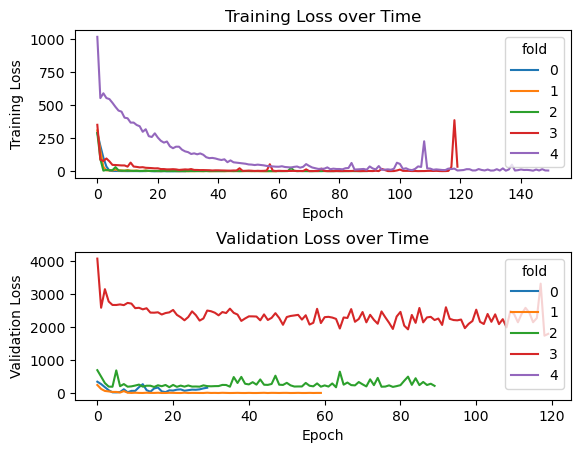

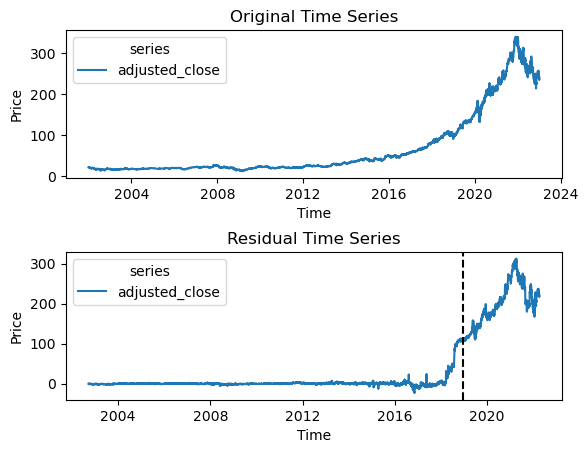

In [19]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 684.4564316479059. Test loss: 35136.27307128906.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 3, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


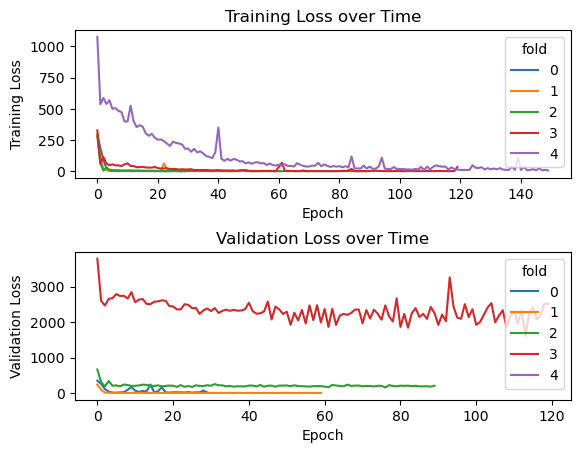

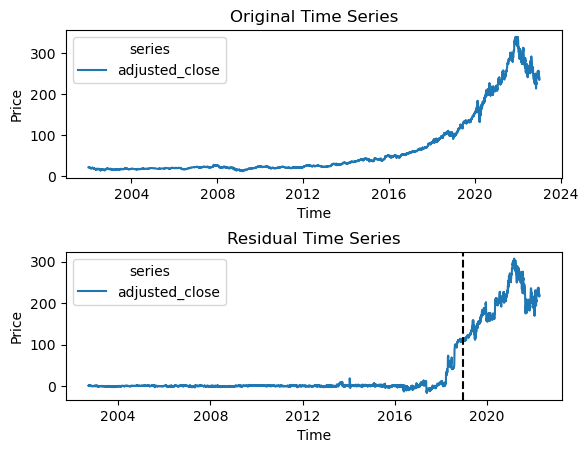

In [20]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=3, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 688.0941457805725. Test loss: 35666.44482421875.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 4, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


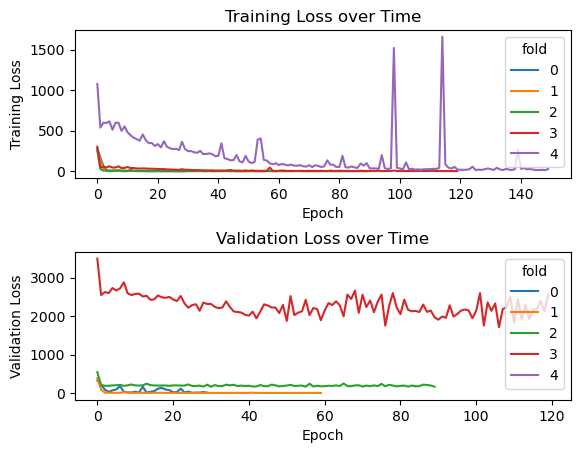

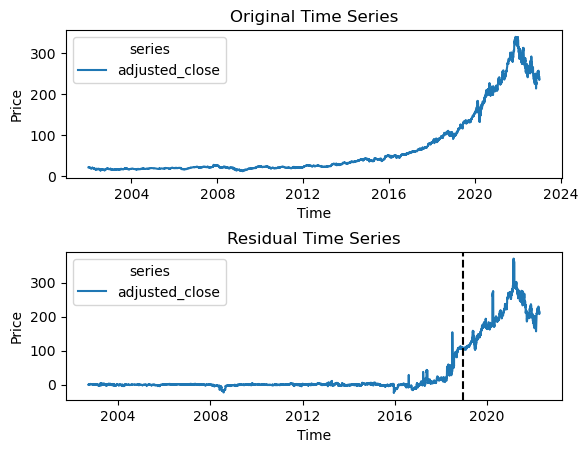

In [21]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=4, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 633.3845020509683. Test loss: 34246.01089477539.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 5, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


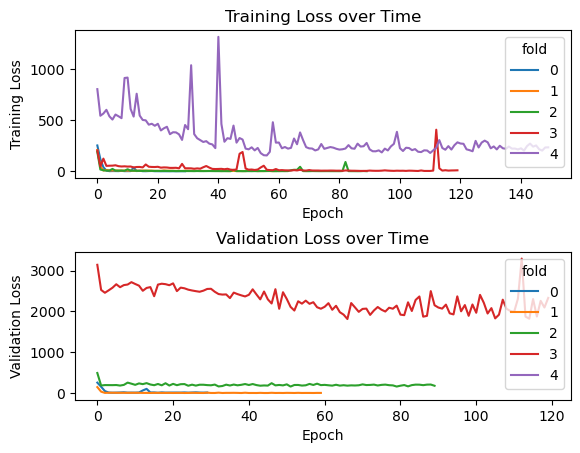

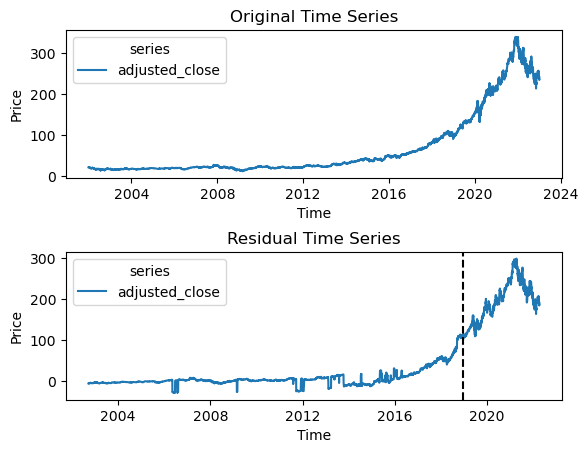

In [22]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=5, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 716.9861958261865. Test loss: 39373.18283081055.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 6, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


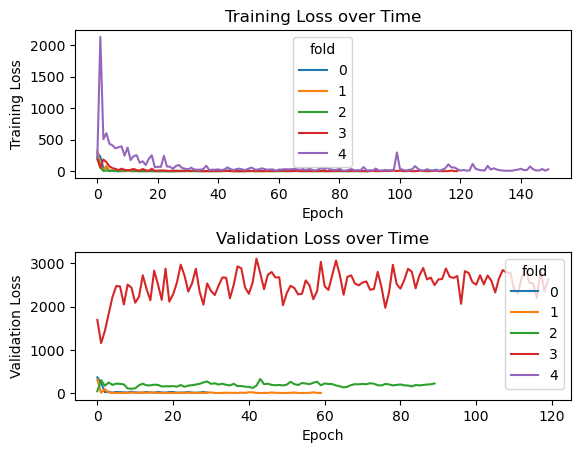

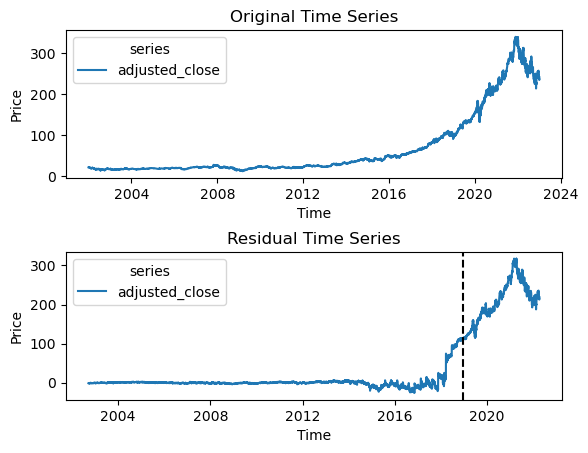

In [23]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=False, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 585.4286341575475. Test loss: 39776.13195800781.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 7, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


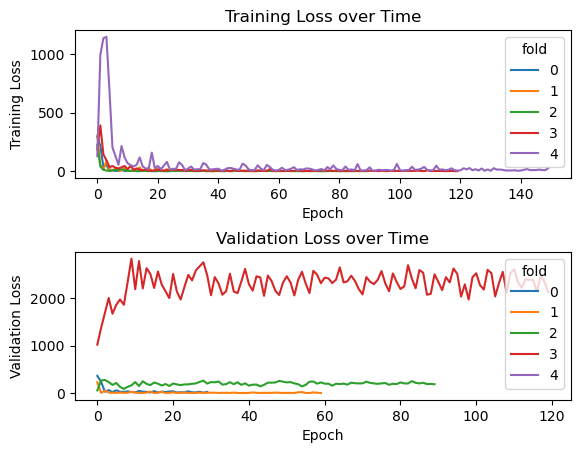

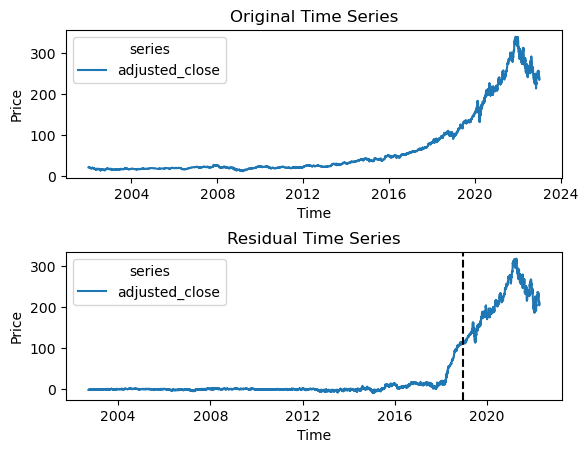

In [24]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 699.538550136181. Test loss: 35763.543825149536.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 8, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


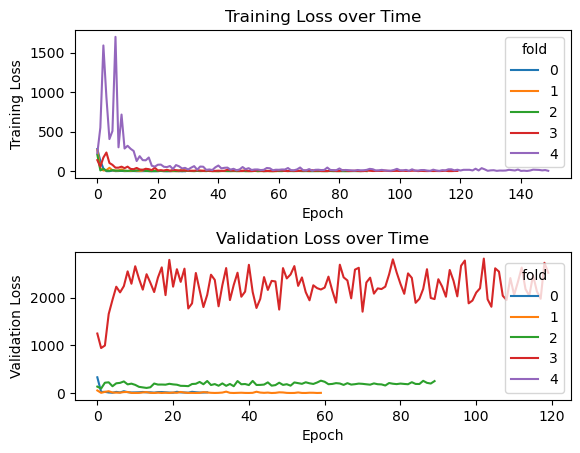

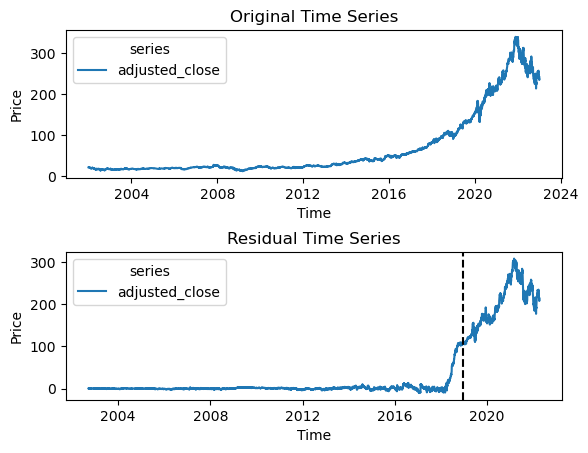

In [25]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=3, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 613.5249070227146. Test loss: 38648.697692871094.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 9, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


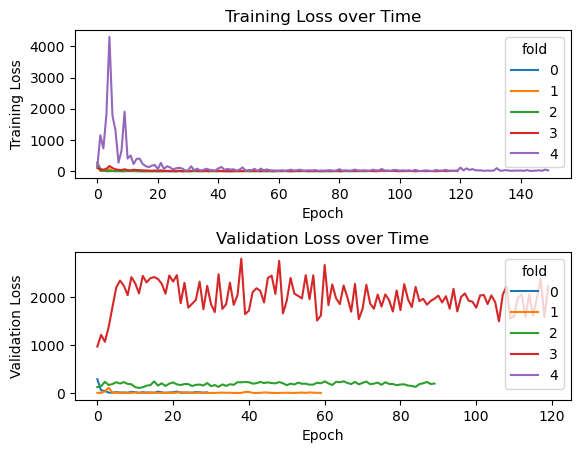

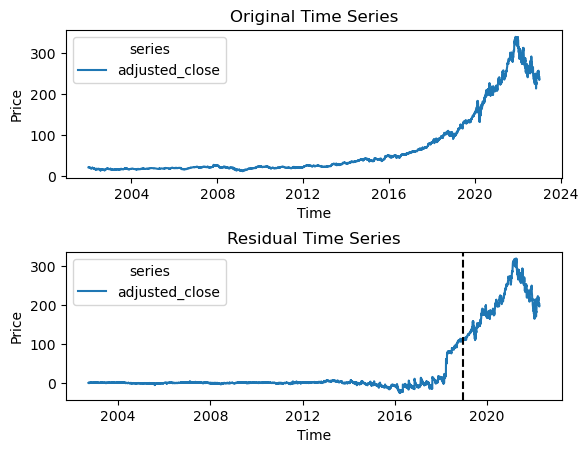

In [26]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=4, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 682.2467240737035. Test loss: 36903.96600341797.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 2, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:240: UserWarning: model_info with the same primary keys already exists with id 10, will not store model information.
  warn(f'model_info with the same primary keys already exists with id {searched_id}, will not store model information.')


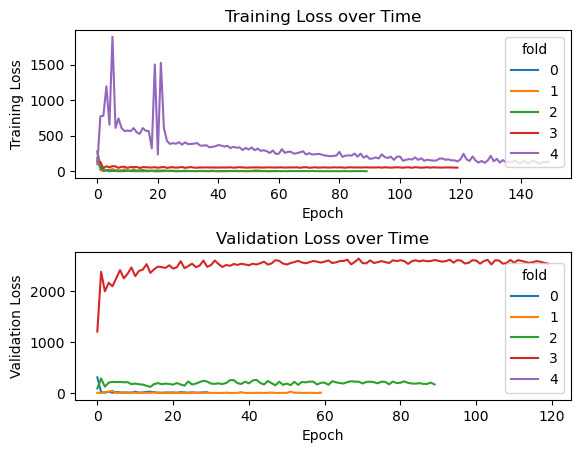

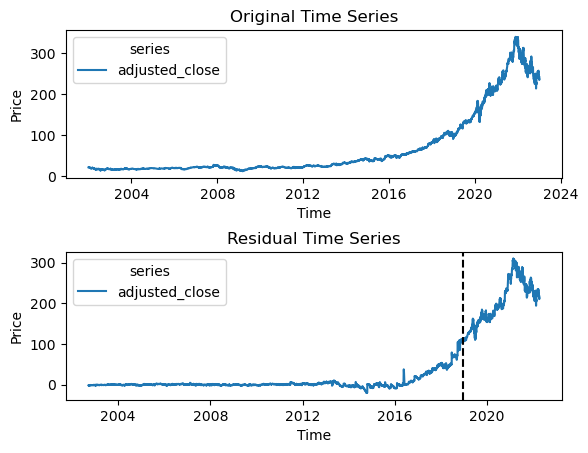

In [27]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=5, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()